# Packages and Dataset Imports

In [4]:
import pandas as pd
import numpy as np
import os
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
import random
from scipy.stats import randint
import xgboost as xgb
import seaborn as sns


from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, average_precision_score, roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn import model_selection
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.feature_selection import RFE


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=15)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [5]:
#dir_path = "https://raw.githubusercontent.com/McGill-MMA-EnterpriseAnalytics/HR_Analytics/main/"
#data_path = os.path.join(dir_path, "data")
#original_file_path = os.path.join(data_path, "hr_attrition.csv")
#df = pd.read_csv(original_file_path)

url = 'https://raw.githubusercontent.com/McGill-MMA-EnterpriseAnalytics/HR_Analytics/main/data/hr_attrition.csv'
df = pd.read_csv(url)

In [6]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


# Custom Functions Summary
* From the data cleaning/transformation notebook

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### returns split data that has been standardized
def standardize(data):
    
    # categorizing features
    ohe_vars = ['Department', 'Gender', 'MaritalStatus', 'OverTime']
    ordinal_vars = ['BusinessTravel', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']
    lab_vars = ['EducationField', 'JobRole']
    
    df_num = [] # list of numerical variables
    cat_vars = ordinal_vars + ohe_vars + lab_vars
    cat_vars.append('Attrition') # target variable
    for i in list(data.columns):
        if i not in cat_vars:
            df_num.append(i)
    
    # standardizing numerical variables
    sc = StandardScaler()
    X = data[df_num]
    y = data['Attrition']
    X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.3, random_state = 6)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5, random_state = 6)
    X_train_std = sc.fit_transform(X_train)
    X_test_std = sc.fit(X_test)
    X_val_std = sc.fit(X_val)
    
    
    return X_train_std, X_test_std, X_val_std, y_train, y_test, y_val


### returns DataFrame with non-standardized numerical variables and encoded categorical variables
def transform_encoding(data):
    # first dropping the unnecessary columns
    if 'EmployeeCount' in list(data.columns):
        data = data.drop(['EmployeeCount', 'EmployeeNumber', 'StandardHours', 'Over18'], axis = 'columns')
    
    # categorizing features
    ohe_vars = ['Department', 'Gender', 'MaritalStatus', 'OverTime']
    ordinal_vars = ['BusinessTravel', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']
    lab_vars = ['EducationField', 'JobRole']
    
    # filtering the data to exclude outliers in the YearsAtCompany and TotalWorkingYears variables
    data = data[data['YearsAtCompany'] < 30]
    data = data[data['TotalWorkingYears'] < 30]
    
    # ordinal encoding of the ordinal variables
    if type(data['BusinessTravel'][0]) == str:
        data['BusinessTravel'] = data['BusinessTravel'].replace({'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2})
    ord_pipeline = Pipeline([('ord_enc', OrdinalEncoder())])
    data[ordinal_vars] = ord_pipeline.fit_transform(data[ordinal_vars])

    # label encoding the education field and job role
    lbl_edu = LabelEncoder()
    edu_encoded = lbl_edu.fit_transform(data[['EducationField']])
    lbl_job = LabelEncoder()
    job_encoded = lbl_job.fit_transform(data[['JobRole']])
    data['EducationField'] = edu_encoded
    data['JobRole'] = job_encoded
    
    # using pd.get_dummies in lieu of OneHotEncoder
    data = pd.concat([data, pd.get_dummies(data[ohe_vars], drop_first = True)], axis = 'columns')
    data = data.drop(ohe_vars, axis = 1)
    
    if type(data['Attrition'][0]) == str:
        data['Attrition'] = data['Attrition'].replace({'Yes': 1, 'No': 0})
    
    return data

In [8]:
df_enc = transform_encoding(df)
X_train_std, X_test_std, X_val_std, y_train, y_test, y_val = standardize(df_enc)
X_train_std

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([[ 0.62766673, -0.85938873,  2.10792391, ...,  1.08978804,
        -0.68739446,  1.64248628],
       [-0.74924025,  0.35071447, -0.005394  , ..., -0.91760963,
         1.45476878, -0.60883309],
       [ 0.74240897, -1.01841667,  2.10792391, ...,  1.08978804,
        -0.68739446,  1.64248628],
       ...,
       [ 0.74240897,  0.57186269,  0.86479573, ...,  1.08978804,
        -0.68739446,  1.64248628],
       [ 0.62766673, -1.33895735, -0.50264527, ...,  1.08978804,
        -0.68739446, -0.60883309],
       [ 1.08663572,  0.4650158 , -0.99989654, ..., -0.91760963,
         1.45476878, -0.60883309]])

In [9]:
#ROC Plot
def plot_roc_curve(fpr, tpr, roc_auc):
#    plt.style.use('classic')
    sns.set_style("darkgrid")
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b+', label = 'AUC = %0.2f' % roc_auc, linestyle = '-')
    plt.fill_between(fpr, tpr, alpha = 0.5, color='gold')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [10]:
#Precision / Recall Plot
def plot_pr_curve(precision, recall, average_precision):
#    plt.style.use('classic')
    sns.set_style("darkgrid")
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='red')   
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

In [11]:
#Learning curve
def plot_learning_curves(X_train, y_train,
                         X_test, y_test,
                         clf,
                         train_marker='o',
                         test_marker='^',
                         scoring='misclassification error',
                         suppress_plot=False, print_model=True,
                         style='fivethirtyeight',
                         legend_loc='best'):
   
    if scoring != 'misclassification error':
        from sklearn import metrics

        scoring_func = {
            'accuracy': metrics.accuracy_score,
            'average_precision': metrics.average_precision_score,
            'f1': metrics.f1_score,
            'f1_micro': metrics.f1_score,
            'f1_macro': metrics.f1_score,
            'f1_weighted': metrics.f1_score,
            'f1_samples': metrics.f1_score,
            'log_loss': metrics.log_loss,
            'precision': metrics.precision_score,
            'recall': metrics.recall_score,
            'roc_auc': metrics.roc_auc_score,
            'adjusted_rand_score': metrics.adjusted_rand_score,
            'mean_absolute_error': metrics.mean_absolute_error,
            'mean_squared_error': metrics.mean_squared_error,
            'median_absolute_error': metrics.median_absolute_error,
            'r2': metrics.r2_score}

        if scoring not in scoring_func.keys():
            raise AttributeError('scoring must be in', scoring_func.keys())

    else:
        def misclf_err(y_predict, y):
            return (y_predict != y).sum() / float(len(y))

        scoring_func = {
            'misclassification error': misclf_err}

    training_errors = []
    test_errors = []

    rng = [int(i) for i in np.linspace(0, X_train.shape[0], 11)][1:]
    for r in rng:
        model = clf.fit(X_train[:r], y_train[:r])

        y_train_predict = clf.predict(X_train[:r])
        y_test_predict = clf.predict(X_test)

        train_misclf = scoring_func[scoring](y_train[:r], y_train_predict)
        training_errors.append(train_misclf)

        test_misclf = scoring_func[scoring](y_test, y_test_predict)
        test_errors.append(test_misclf)

    if not suppress_plot:
        with plt.style.context(style):
            plt.plot(np.arange(10, 101, 10), training_errors,
                     label='training set', marker=train_marker)
            plt.plot(np.arange(10, 101, 10), test_errors,
                     label='test set', marker=test_marker)
            plt.xlabel('Training set size in percent')

    if not suppress_plot:
        with plt.style.context(style):
            plt.ylabel('Performance')
            if print_model:
                plt.title('Learning Curves\n\n{}\n'.format(model))
            plt.legend(loc=legend_loc, numpoints=1)
            plt.xlim([0, 110])
            max_y = max(max(test_errors), max(training_errors))
            min_y = min(min(test_errors), min(training_errors))
            plt.ylim([min_y - min_y * 0.15, max_y + max_y * 0.15])
    errors = (training_errors, test_errors)
    return errors

In [12]:
#Validation curve
from yellowbrick.model_selection import (
ValidationCurve,
)

def plot_val_curve(X,y, clf):
    fig, ax = plt.subplots(figsize=(6, 4))
    vc_viz = ValidationCurve(clf, param_name="max_depth", param_range=np.arange(1, 11), cv=10, n_jobs=-1, )
    vc_viz.fit(X, y)
    vc_viz.poof()

In [26]:
def clf_score(clf, X_train, y_train, X_val, y_val, train=True):
    if train:
        print("Train Result:\n")
        print("Accuracy: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("F1 score: {0:.4f}\n".format(f1_score(y_train, clf.predict(X_train), average='weighted')))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
        
        plot_learning_curves(X_train, y_train, X_val, y_val, clf)
        plt.show()

    elif train == False:
        print("Validation Result:\n")
        print("Accuracy: {0:.4f}\n".format(accuracy_score(y_val, clf.predict(X_val))))
        print("F1 score: {0:.4f}\n".format(f1_score(y_val, clf.predict(X_val), average='weighted')))
        
        precision, recall, _ = precision_recall_curve(y_val, clf.predict(X_val))
        average_precision = average_precision_score(y_val, clf.predict(X_val))
        plot_pr_curve(precision, recall, average_precision)
        
        fpr, tpr, _ = roc_curve(y_val, clf.predict(X_val))
        roc_auc = roc_auc_score(y_val, clf.predict(X_val))
        print("AUC-ROC: {0:.3f}\n".format(roc_auc))
        plot_roc_curve(fpr, tpr, roc_auc)
        
        print("Classification Report: \n {}\n".format(classification_report(y_val, clf.predict(X_val))))
        print("Confusion Matrix: \n {}\n".format(pd.DataFrame(metrics.confusion_matrix(y_val, clf.predict(X_val),
                                                                  labels=[0,1]),index=['true:0','true:1'], columns=['pred:0','pred:1'])))

        
        
        print("End of validation Result\n")

In [27]:
def clf_evals(clf, X_train, y_train, X_val, y_val, X_test, y_test):
    acc_score_val = accuracy_score(y_val, clf.predict(X_val))
    avg_precision_val = average_precision_score(y_val, clf.predict(X_val))
    roc_auc_val = roc_auc_score(y_val, clf.predict(X_val))
    
    acc_score_test = accuracy_score(y_test, clf.predict(X_test))
    avg_precision_test = average_precision_score(y_test, clf.predict(X_test))
    roc_auc_test = roc_auc_score(y_test, clf.predict(X_test))
    
    # function to return metrics of a classifier as a dictionary
    
    return {'Accuracy Validation': acc_score_val, 'Accuracy Test': acc_score_test, 'Precision Validation': avg_precision_val, 'Precision Test': avg_precision_test, 'AUC-ROC Validation': roc_auc_val, 'AUC-ROC Test': roc_auc_test}

In [28]:
# function which returns the most important features using RFE with a desired number of features and desired estimator
def important_features(estim, num):
    X_enc = df_enc.drop('Attrition', axis = 'columns')
    y_enc = df_enc['Attrition']

    rfe = RFE(estimator = estim, step = 1, n_features_to_select = num)
    rfe.fit(X_enc, y_enc)

    feats = pd.DataFrame(rfe.ranking_)
    feats['Feature'] = X_enc.columns

    feats_to_use = list(feats[feats[0] < 2]['Feature'])
    
    return feats_to_use

In [29]:
# takes in list of important features, applies train_test_split and SMOTE on the dataset using those features
def split_and_smote(feats_to_use):
    X_enc = df_enc[feats_to_use]
    y_enc = df_enc['Attrition']

    X_enc_train, X_enc_val_test, y_enc_train, y_enc_val_test = train_test_split(X_enc, y_enc, test_size = 0.3, random_state = 6)

    X_enc_val, X_enc_test, y_enc_val, y_enc_test = train_test_split(X_enc_val_test, y_enc_val_test, test_size = 0.5, random_state = 6)

    sm = SMOTE(random_state=42)
    X_enc_train_sm, y_enc_train_sm = sm.fit_sample(X_enc_train, y_enc_train)
    
    return X_enc_train_sm, y_enc_train_sm, X_enc_val, y_enc_val, X_enc_test, y_enc_test

# GradientBoostingClassifier

In [30]:
from sklearn.metrics import f1_score
df_enc = transform_encoding(df)
X = df_enc.drop(['Attrition'], axis=1)
y = df_enc['Attrition']

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.3, random_state = 4)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5, random_state = 4)



C:\Users\USER\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [31]:
params = {
    
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }
    
}

gbc = GradientBoostingClassifier()

gb = GridSearchCV(estimator=gbc,param_grid=params,cv=3,scoring='accuracy',n_jobs=-1)
gb.fit(X_train,y_train)


gb.best_params_

SyntaxError: invalid syntax (<ipython-input-31-3d350159fbce>, line 14)

Validation Result:

Accuracy: 0.8873

F1 score: 0.8784



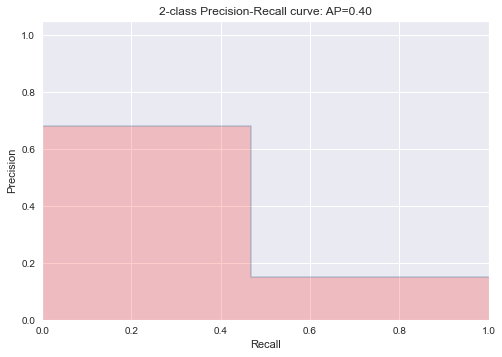

AUC-ROC: 0.715



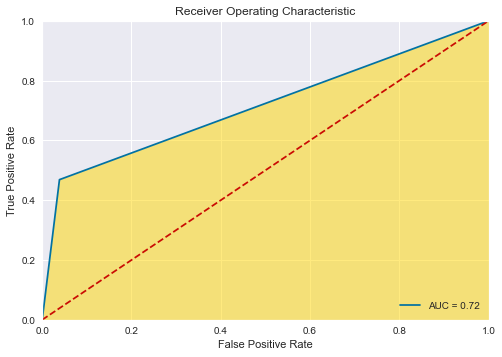

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.96      0.94       181
           1       0.68      0.47      0.56        32

    accuracy                           0.89       213
   macro avg       0.80      0.72      0.75       213
weighted avg       0.88      0.89      0.88       213


Confusion Matrix: 
         pred:0  pred:1
true:0     174       7
true:1      17      15

End of validation Result



In [32]:
sm = SMOTE(random_state = 6)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

gb_params ={
    'n_estimators': 1500,
    'max_features': 0.9,
    'learning_rate' : 0.25,
    'max_depth': 4,
    'min_samples_leaf': 2,
    'subsample': 1,
    'max_features' : 'sqrt',
    'verbose': 0
}

clf = GradientBoostingClassifier(**gb_params, random_state = 4)
clf.fit(X_train_sm, y_train_sm)
clf_score(clf, X_train_sm, y_train_sm, X_val, y_val, train = False)

### Validation Set Metrics

Validation Result:

Accuracy: 0.8873

F1 score: 0.8784



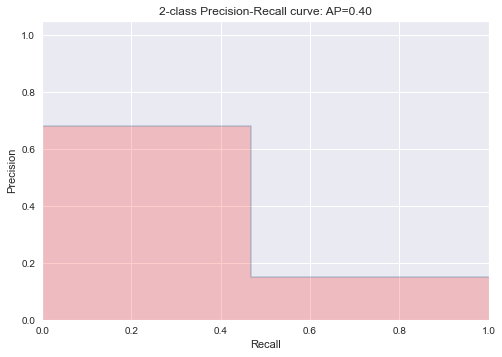

AUC-ROC: 0.715



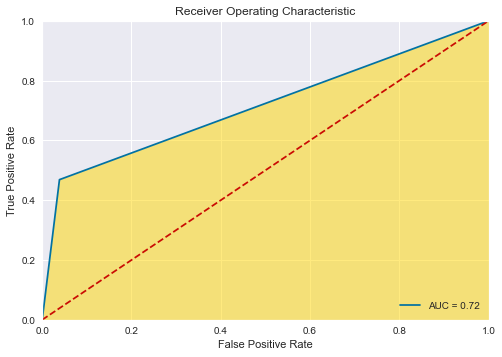

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.96      0.94       181
           1       0.68      0.47      0.56        32

    accuracy                           0.89       213
   macro avg       0.80      0.72      0.75       213
weighted avg       0.88      0.89      0.88       213


Confusion Matrix: 
         pred:0  pred:1
true:0     174       7
true:1      17      15

End of validation Result



In [33]:
clf_score(clf, X_train_sm, y_train_sm, X_val, y_val, train = False)

### Test Set Metrics

Validation Result:

Accuracy: 0.8873

F1 score: 0.8771



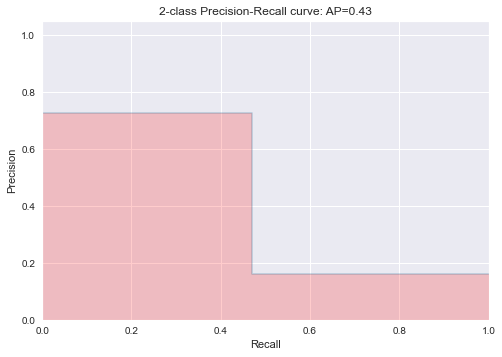

AUC-ROC: 0.719



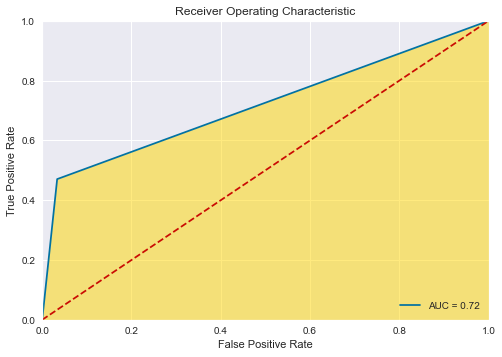

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       179
           1       0.73      0.47      0.57        34

    accuracy                           0.89       213
   macro avg       0.82      0.72      0.75       213
weighted avg       0.88      0.89      0.88       213


Confusion Matrix: 
         pred:0  pred:1
true:0     173       6
true:1      18      16

End of validation Result



In [34]:
clf_score(clf, X_train_sm, y_train_sm, X_test, y_test, train = False)

### Other Metrics

In [35]:
pd.DataFrame({'Score': clf_evals(clf, X_train_sm, y_train_sm, X_val, y_val, X_test, y_test)})

,Score
AUC-ROC Test,0.718534
AUC-ROC Validation,0.715038
Accuracy Test,0.887324
Accuracy Validation,0.887324
Precision Test,0.426753
Precision Validation,0.399414
